# 컴퓨터 비전 학습 경진대회, Dacon.io
### https://dacon.io/competitions/official/235626/overview/

6가지의 모델을 Ensemble하여 사용하였습니다. <br>

모델: thin_resnet, xception, inception, densenet, vggnet, resnet <br>
thin_resnet은 resnet기반으로 만든 조금 작은 모델입니다. <br>
나머지 모델들은 keras(tensorflow)의 application을 그대로 사용하였습니다. <br>

train dataset으로 학습을 시키고 test dataset을 predict한 결과 중 일정 점수 이상을
받은 데이터들을 train dataset에 추가하여 다시 학습하였습니다.

Ensemble은 여러 모델의 각 fold로 예측한 값의 root sum을 사용하였고, <br>
Loss는 mse, optimizer는 adam을 사용하였습니다. <br>

Data Augmentation은 keras의 RandomRotation과 직접 구현한 RandomRoll을 사용하였습니다.
keras의 RandomTranslation은 성능이 좋지 않아 사용하지 않았습니다.


In [2]:
!nvidia-smi

Sat Aug 29 18:29:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    11W / 190W |    731MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [1]:
import os
import time
import glob
import shutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from albumentations import Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, Rotate, RandomCrop, RandomBrightnessContrast

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D, Permute
from tensorflow.keras.layers import MaxPooling1D, Dropout, Reshape, Multiply, Conv2D, MaxPool2D, LSTM, Add, Lambda, AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomTranslation, RandomRotation, RandomZoom
from tensorflow_addons.layers.netvlad import NetVLAD
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB4, EfficientNetB2, EfficientNetB1

In [17]:
train_csv = pd.read_csv('data/train.csv')
test_csv = pd.read_csv('data/test.csv')
submission_csv = pd.read_csv('data/submission.csv')

In [18]:
train_csv

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [19]:
label_encoder = LabelEncoder()

# TRAIN
train_letters_char = train_csv['letter'].values
train_letters_int = label_encoder.fit_transform(train_letters_char)
train_letters = keras.utils.to_categorical(train_letters_int)

train_pixels = train_csv.loc[:, '0':'783'].values
train_pixels = train_pixels.astype(np.float32)
train_pixels = train_pixels.reshape((-1, 28, 28, 1))

train_digits_int = train_csv['digit'].values
train_digits = keras.utils.to_categorical(train_digits_int)

# TEST
test_letters_char = test_csv['letter'].values
test_letters_int = label_encoder.fit_transform(test_letters_char)
test_letters = keras.utils.to_categorical(test_letters_int)

test_pixels = test_csv.loc[:, '0':'783'].values
test_pixels = test_pixels.astype(np.float32)
test_pixels = test_pixels.reshape((-1, 28, 28, 1))

print(train_letters.shape, train_letters.dtype)
print(train_digits.shape, train_digits.dtype)
print(train_pixels.shape, train_pixels.dtype)

print(test_letters.shape, test_letters.dtype)
print(test_pixels.shape, test_pixels.dtype)

(2048, 26) float32
(2048, 10) float32
(2048, 28, 28, 1) float32
(20480, 26) float32
(20480, 28, 28, 1) float32


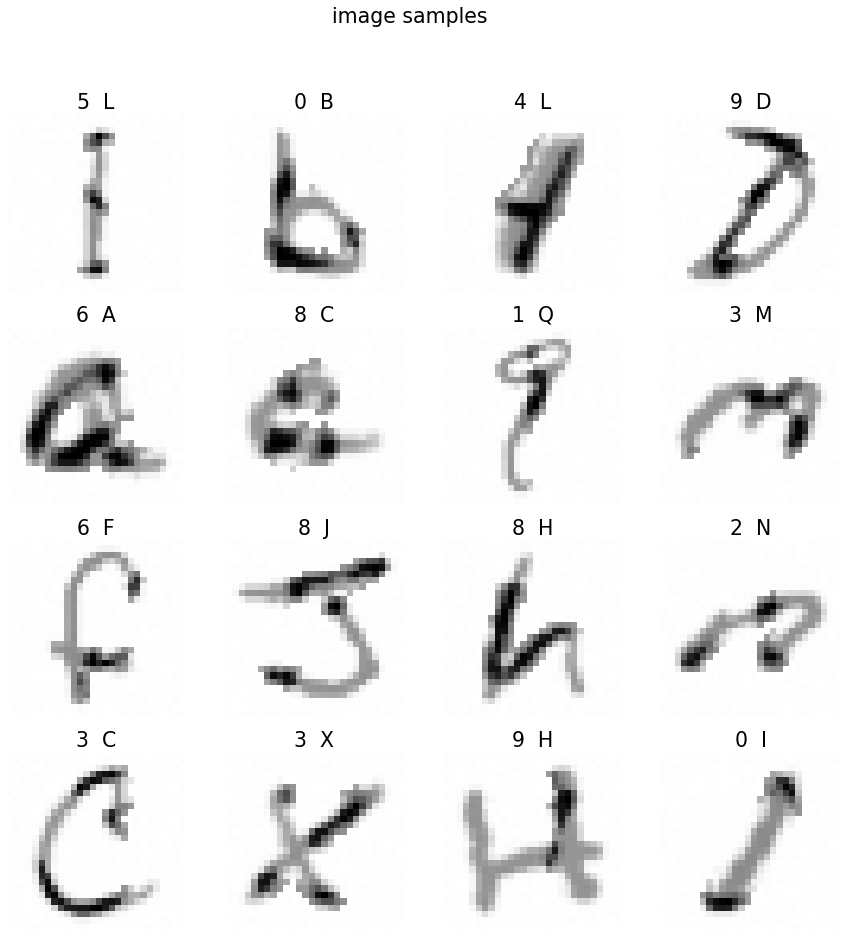

In [20]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = train_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0.0
        # img[img >= 150] = 1.0
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{train_digits_int[i * 4 + j]}  {train_letters_char[i * 4 + j]}')
plt.show()


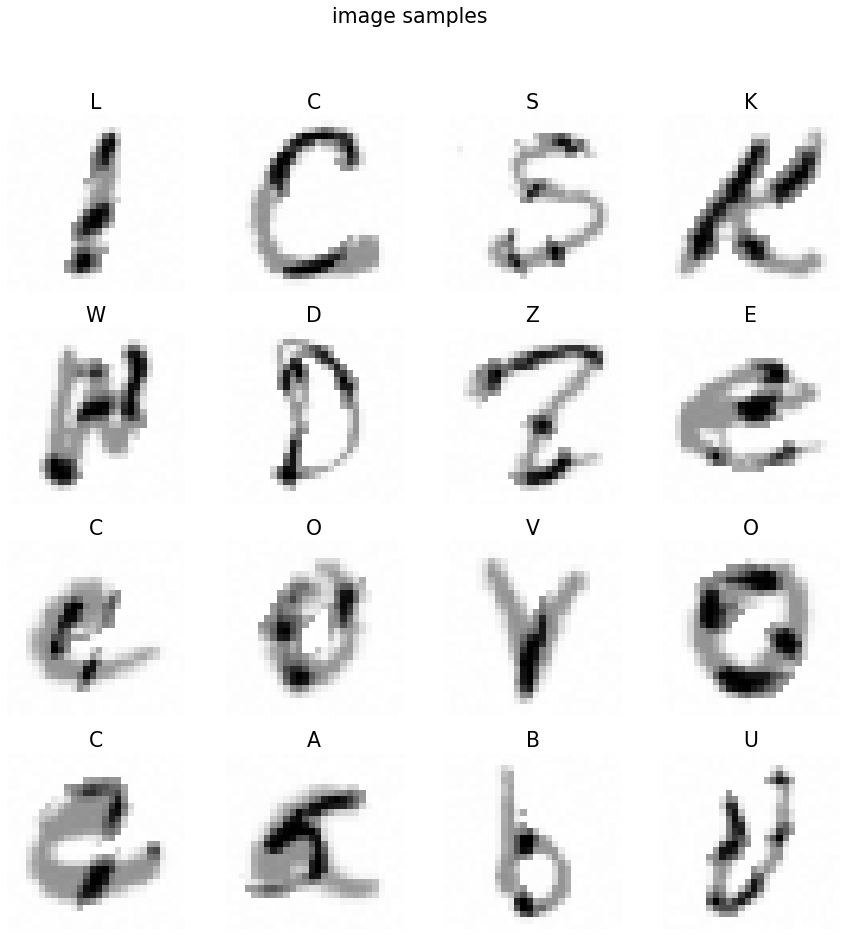

In [21]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = test_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0
        # img[img >= 150] = 1
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{test_letters_char[i * 4 + j]}')
plt.show()


In [22]:
input_shape_1 = train_letters.shape[1:]
input_shape_2 = train_pixels.shape[1:]
output_size = train_digits.shape[1]

print(input_shape_1)
print(input_shape_2)
print(output_size)

(26,)
(28, 28, 1)
10


In [23]:
class RandomRollLayer(tf.keras.layers.Layer):
    """Shift data"""

    def __init__(self, roll_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.roll_limit = roll_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.roll_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[1]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=1)

        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[2]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=2)
            
        return pixels

    def get_config(self):
        config = {
            'roll_limit': self.roll_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

class RandomAddLayer(tf.keras.layers.Layer):
    """Add data"""

    def __init__(self, add_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.add_limit = add_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.add_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            add = tf.random.uniform(shape=[], minval=-self.add_limit, maxval=self.add_limit, dtype=tf.float32)
            pixels = pixels + add

        return pixels

    def get_config(self):
        config = {
            'add_limit': self.add_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

class RandomMultipleLayer(tf.keras.layers.Layer):
    """Multiple data"""

    def __init__(self, multiple_limit=0.5, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.multiple_limit = multiple_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.multiple_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            multiple = tf.random.uniform(shape=[], minval=-self.multiple_limit, maxval=self.multiple_limit, dtype=tf.float32)
            pixels = pixels * (1 + multiple)

        return pixels
    
    def get_config(self):
        config = {
            'multiple_limit': self.multiple_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

In [24]:
def thin_resnet_model(input_shape_1, input_shape_2, output_size=10, num_clusters=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2
    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    # y = RandomTranslation(0.1, 0.1)(y)
    # y = RandomRotation(0.1)(y)
    # y = RandomZoom(0.1)(y)

    # CONV 1
    y = Conv2D(64, (7, 7), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPool2D((2, 2), strides=(2, 2))(y)

    # CONV 2 - 1
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y2 = Conv2D(96, (1, 1), padding='valid')(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 2 - 2
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y = Add()([y1, y])
    y = Activation('relu')(y)


    # CONV 3 - 1
    y1 = Conv2D(96, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(128, (1, 1), padding='valid')(y2)
    # y2 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)
  
    # CONV 3 - 2
    y1 = Conv2D(96, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 4 - 1
    y1 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(256, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 4 - 2
    y1 = Conv2D(128, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization(gamma_initializer='zeros')(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 5 - 1
    y1 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(512, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(512, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 5 - 2
    y1 = Conv2D(256, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 6
    y = Conv2D(512, (2, 2), padding='valid')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # y = Reshape((-1, 512))(y)
    # y = Flatten()(y)
    y = GlobalAveragePooling2D()(y)
    # y = NetVLAD(num_clusters=num_clusters)(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dropout(0.3)(y)

    y = Dense(output_size)(y)
    y = Activation('softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='thin_resnet_model')
    # optimizer = tfa.optimizers.AdamW(learning_rate=0.05, weight_decay=0.0001)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return model

In [25]:
from tensorflow.keras.applications import VGG19


def vggnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = VGG19(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='vggnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [26]:
from tensorflow.keras.applications import ResNet101V2


def resnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = ResNet101V2(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='resnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [27]:
from tensorflow.keras.applications import DenseNet121


def densenet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = DenseNet121(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='densenet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [28]:
from tensorflow.keras.applications import Xception


def xception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = Xception(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='xception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [29]:
from tensorflow.keras.applications import InceptionV3


def inception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = InceptionV3(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='inception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

In [30]:
def k_fold_validation(model_fn, n_splits=5, verbose=1):
    kf = KFold(n_splits=n_splits)
    sum_accuracy = 0
    sum_epoch = 0
    start_time = time.time()
    for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
        model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

        train_data = [train_letters[train_index], train_pixels[train_index]]
        train_label = train_digits[train_index]

        val_data = [train_letters[val_index], train_pixels[val_index]]
        val_label = train_digits[val_index]

        history = model.fit(
            train_data, train_label,
            epochs=EPOCHS,
            validation_data=(val_data, val_label),
            batch_size=BATCH_SIZE,
            verbose=verbose,
            callbacks=[early_stopping],
        )

        sum_epoch += len(history.history['val_accuracy'])
        sum_accuracy += max(history.history['val_accuracy'])
        
        if verbose >= 0:            
            print(f'{i+1}/{n_splits} fold result: ')
            print('epoch num:', len(history.history['val_accuracy']))
            print('best val accuracy: ', max(history.history['val_accuracy']))
            print('average 20: ', np.mean(history.history['val_accuracy'][-20:]))
            print('='*50)

    print('Average Accuracy: ', sum_accuracy/n_splits)
    print('Average Epoch: ', sum_epoch/n_splits)
    print('Time taken: ', time.time() - start_time)
    print('='*50)

In [ ]:
k_fold_validation(resnet_model, verbose=1)

## 실험 결과

### Augumentation
No Augumentation -> 0.69
RandomRollLayer(roll_limit=0.2, u=0.8)(y) -> 0.835
Roll + ResNet-D -> 0.824
RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant')(y) -> 0.768
RandomRotation(factor=(-0.2, 0.2), fill_mode='constant')(y) -> 0.731
RandomAddLayer(add_limit=0.1, u=0.8)(y) -> 0.751
RandomZoom(height_factor=(0, 0.2), width_factor=(0, 0.2), fill_mode='reflect')(y) -> 0.689

### Model
thin_resnet_model -> 0.835
xception_model -> 0.894
inception_model -> 0.886
densenet_model -> 0.885
vggnet_model -> 0.833
resnet_model -> 0.840

### Loss
RMSProp + categorical_crossentropy -> 0.823

### Batch size
smaller is better

In [70]:
model_fn_list = [
    thin_resnet_model,
    vggnet_model,
    resnet_model,
    densenet_model,
    xception_model,
    inception_model
]

EPOCHS = 300
BATCH_SIZE = 16
CHECKPOINT_PATH = 'checkpoint/'
MODEL_PATH = 'model/'

In [71]:
if os.path.isdir(CHECKPOINT_PATH):
    shutil.rmtree(CHECKPOINT_PATH, ignore_errors=True)
os.mkdir(CHECKPOINT_PATH)

if os.path.isdir(MODEL_PATH):
    shutil.rmtree(MODEL_PATH, ignore_errors=True)
os.mkdir(MODEL_PATH)

In [75]:
for model_fn in model_fn_list:
    kf = KFold(n_splits=5)
    for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
        start_time = time.time()
        model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

        # Validation 점수가 가장 좋은 모델만 저장합니다.
        checkpoint_path = os.path.join(CHECKPOINT_PATH, f'{model.name}_fold{i+1}')
        if os.path.isdir(checkpoint_path):
            shutil.rmtree(checkpoint_path, ignore_errors=True)
        os.mkdir(checkpoint_path)
        checkpoint_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
        checkpoint = ModelCheckpoint(filepath=checkpoint_file_path, monitor='val_accuracy', verbose=0, save_best_only=True)

        # 30회 간 Validation 점수가 좋아지지 않으면 중지합니다.
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

        train_data = [train_letters[train_index], train_pixels[train_index]]
        train_label = train_digits[train_index]

        val_data = [train_letters[val_index], train_pixels[val_index]]
        val_label = train_digits[val_index]

        history = model.fit(
            train_data, train_label,
            epochs=EPOCHS,
            validation_data=(val_data, val_label),
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping, checkpoint],
        )

        # 가장 좋은 모델의 weight를 불러옵니다.
        weigth_file = glob.glob('{}/*.hdf5'.format(checkpoint_path))[-1]
        model.load_weights(weigth_file)
        model.save(os.path.join(MODEL_PATH, f'{model.name}_{i+1}.h5'))
        
        shutil.rmtree(checkpoint_path, ignore_errors=True)

        epoch_num = len(history.history['val_accuracy'])
        max_accuracy = max(history.history['val_accuracy'])
        print('='*50)
        print(f'Result of {model.name}, fold {i+1}')
        print(f'Epoch: {epoch_num}')
        print(f'Accuracy: {max_accuracy}')
        print('Time taken: ', time.time() - start_time)
        print('='*50)



Epoch 1/300
986/986 [==============================] - 13s 13ms/step - loss: 0.0873 - accuracy: 0.2726 - val_loss: 0.0984 - val_accuracy: 0.2552
Epoch 2/300
986/986 [==============================] - 13s 13ms/step - loss: 0.0748 - accuracy: 0.4154 - val_loss: 0.0779 - val_accuracy: 0.4170
Epoch 3/300
986/986 [==============================] - 13s 13ms/step - loss: 0.0629 - accuracy: 0.5301 - val_loss: 0.0449 - val_accuracy: 0.6753
Epoch 4/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0475 - accuracy: 0.6573 - val_loss: 0.0995 - val_accuracy: 0.3034
Epoch 5/300
986/986 [==============================] - 13s 13ms/step - loss: 0.0386 - accuracy: 0.7234 - val_loss: 0.0368 - val_accuracy: 0.7410
Epoch 6/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0335 - accuracy: 0.7650 - val_loss: 0.0376 - val_accuracy: 0.7349
Epoch 7/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0293 - accuracy: 0.7970 - val_loss: 0.0544 - val_ac

Epoch 6/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0367 - accuracy: 0.7407 - val_loss: 0.0904 - val_accuracy: 0.4094
Epoch 7/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0318 - accuracy: 0.7770 - val_loss: 0.0583 - val_accuracy: 0.6106
Epoch 8/300
986/986 [==============================] - 13s 13ms/step - loss: 0.0286 - accuracy: 0.8025 - val_loss: 0.0187 - val_accuracy: 0.8765
Epoch 9/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0253 - accuracy: 0.8274 - val_loss: 0.0175 - val_accuracy: 0.8795
Epoch 10/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0238 - accuracy: 0.8354 - val_loss: 0.0184 - val_accuracy: 0.8752
Epoch 11/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0223 - accuracy: 0.8456 - val_loss: 0.0204 - val_accuracy: 0.8617
Epoch 12/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0211 - accuracy: 0.8571 - val_loss: 0.0163 - val

Epoch 2/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0767 - accuracy: 0.4026 - val_loss: 0.0966 - val_accuracy: 0.3014
Epoch 3/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0647 - accuracy: 0.5125 - val_loss: 0.0895 - val_accuracy: 0.3219
Epoch 4/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0530 - accuracy: 0.6133 - val_loss: 0.0963 - val_accuracy: 0.3229
Epoch 5/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0442 - accuracy: 0.6859 - val_loss: 0.0467 - val_accuracy: 0.6578
Epoch 6/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0373 - accuracy: 0.7376 - val_loss: 0.0335 - val_accuracy: 0.7656
Epoch 7/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0321 - accuracy: 0.7757 - val_loss: 0.0204 - val_accuracy: 0.8584
Epoch 8/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0276 - accuracy: 0.8086 - val_loss: 0.0178 - val_ac

986/986 [==============================] - 13s 13ms/step - loss: 0.0225 - accuracy: 0.8472 - val_loss: 0.0124 - val_accuracy: 0.9158
Epoch 12/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0213 - accuracy: 0.8564 - val_loss: 0.0309 - val_accuracy: 0.7859
Epoch 13/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0205 - accuracy: 0.8621 - val_loss: 0.0288 - val_accuracy: 0.7991
Epoch 14/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0185 - accuracy: 0.8743 - val_loss: 0.0303 - val_accuracy: 0.7874
Epoch 15/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0188 - accuracy: 0.8745 - val_loss: 0.0168 - val_accuracy: 0.8881
Epoch 16/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0179 - accuracy: 0.8806 - val_loss: 0.0241 - val_accuracy: 0.8343
Epoch 17/300
986/986 [==============================] - 12s 13ms/step - loss: 0.0170 - accuracy: 0.8855 - val_loss: 0.0089 - val_accuracy

986/986 [==============================] - 12s 12ms/step - loss: 0.0113 - accuracy: 0.9248 - val_loss: 0.0126 - val_accuracy: 0.9132
Epoch 34/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0112 - accuracy: 0.9274 - val_loss: 0.0221 - val_accuracy: 0.8503.0112 
Epoch 35/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0113 - accuracy: 0.9256 - val_loss: 0.0088 - val_accuracy: 0.9394
Epoch 36/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0111 - accuracy: 0.9262 - val_loss: 0.0113 - val_accuracy: 0.9249
Epoch 37/300
986/986 [==============================] - 12s 12ms/step - loss: 0.0107 - accuracy: 0.9294 - val_loss: 0.0071 - val_accuracy: 0.9551
Result of thin_resnet_model, fold 5
Epoch: 37
Accuracy: 0.9662607908248901
Time taken:  455.87963223457336
Epoch 1/300
986/986 [==============================] - 38s 39ms/step - loss: 0.0893 - accuracy: 0.1868 - val_loss: 0.0928 - val_accuracy: 0.2440
Epoch 2/300
986/986 [====

986/986 [==============================] - 37s 38ms/step - loss: 0.0026 - accuracy: 0.9847 - val_loss: 0.0079 - val_accuracy: 0.9518
Epoch 50/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0027 - accuracy: 0.9839 - val_loss: 0.0101 - val_accuracy: 0.9391
Epoch 51/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0028 - accuracy: 0.9843 - val_loss: 0.0085 - val_accuracy: 0.9490
Epoch 52/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0035 - accuracy: 0.9800 - val_loss: 0.0089 - val_accuracy: 0.9457
Epoch 53/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0029 - accuracy: 0.9833 - val_loss: 0.0082 - val_accuracy: 0.9531
Epoch 54/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0023 - accuracy: 0.9868 - val_loss: 0.0096 - val_accuracy: 0.9419
Epoch 55/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0029 - accuracy: 0.9826 - val_loss: 0.0106 - val_accuracy

986/986 [==============================] - 37s 38ms/step - loss: 0.0053 - accuracy: 0.9676 - val_loss: 0.0056 - val_accuracy: 0.9642
Epoch 32/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0048 - accuracy: 0.9711 - val_loss: 0.0038 - val_accuracy: 0.9777
Epoch 33/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0054 - accuracy: 0.9684 - val_loss: 0.0029 - val_accuracy: 0.9827
Epoch 34/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0046 - accuracy: 0.9727 - val_loss: 0.0032 - val_accuracy: 0.9789
Epoch 35/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0054 - accuracy: 0.9680 - val_loss: 0.0041 - val_accuracy: 0.9759
Epoch 36/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0039 - accuracy: 0.9771 - val_loss: 0.0041 - val_accuracy: 0.9746
Epoch 37/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0047 - accuracy: 0.9716 - val_loss: 0.0032 - val_accuracy

986/986 [==============================] - 37s 37ms/step - loss: 0.0049 - accuracy: 0.9704 - val_loss: 0.0043 - val_accuracy: 0.9726
Epoch 42/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0036 - accuracy: 0.9784 - val_loss: 0.0030 - val_accuracy: 0.9827
Epoch 43/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0037 - accuracy: 0.9779 - val_loss: 0.0026 - val_accuracy: 0.9833
Epoch 44/300
986/986 [==============================] - 40s 40ms/step - loss: 0.0044 - accuracy: 0.9733 - val_loss: 0.0040 - val_accuracy: 0.9756
Epoch 45/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0033 - accuracy: 0.9805 - val_loss: 0.0034 - val_accuracy: 0.9777
Epoch 46/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0040 - accuracy: 0.9760 - val_loss: 0.0028 - val_accuracy: 0.9833
Epoch 47/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0037 - accuracy: 0.9775 - val_loss: 0.0052 - val_accuracy

Epoch 1/300
986/986 [==============================] - 38s 39ms/step - loss: 0.0867 - accuracy: 0.2305 - val_loss: 0.0825 - val_accuracy: 0.2958
Epoch 2/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0701 - accuracy: 0.4339 - val_loss: 0.0716 - val_accuracy: 0.4320
Epoch 3/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0573 - accuracy: 0.5686 - val_loss: 0.0666 - val_accuracy: 0.4637
Epoch 4/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0474 - accuracy: 0.6555 - val_loss: 0.0386 - val_accuracy: 0.7156
Epoch 5/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0395 - accuracy: 0.7223 - val_loss: 0.0294 - val_accuracy: 0.7965
Epoch 6/300
986/986 [==============================] - 37s 38ms/step - loss: 0.0321 - accuracy: 0.7798 - val_loss: 0.0462 - val_accuracy: 0.6492
Epoch 7/300
986/986 [==============================] - 38s 38ms/step - loss: 0.0252 - accuracy: 0.8307 - val_loss: 0.0150 - val_ac

986/986 [==============================] - 62s 62ms/step - loss: 0.0620 - accuracy: 0.5286 - val_loss: 0.1303 - val_accuracy: 0.1337
Epoch 3/300
986/986 [==============================] - 62s 62ms/step - loss: 0.0446 - accuracy: 0.6838 - val_loss: 0.1086 - val_accuracy: 0.2453
Epoch 4/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0331 - accuracy: 0.7732 - val_loss: 0.0327 - val_accuracy: 0.7712
Epoch 5/300
986/986 [==============================] - 62s 62ms/step - loss: 0.0266 - accuracy: 0.8232 - val_loss: 0.0370 - val_accuracy: 0.7410
Epoch 6/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0227 - accuracy: 0.8491 - val_loss: 0.0219 - val_accuracy: 0.8534
Epoch 7/300
986/986 [==============================] - 62s 62ms/step - loss: 0.0202 - accuracy: 0.8650 - val_loss: 0.0266 - val_accuracy: 0.8247
Epoch 8/300
986/986 [==============================] - 62s 62ms/step - loss: 0.0194 - accuracy: 0.8720 - val_loss: 0.0381 - val_accuracy: 0.73

Epoch 7/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0221 - accuracy: 0.8525 - val_loss: 0.0575 - val_accuracy: 0.5614
Epoch 8/300
986/986 [==============================] - 63s 63ms/step - loss: 0.0194 - accuracy: 0.8715 - val_loss: 0.0798 - val_accuracy: 0.4614
Epoch 9/300
986/986 [==============================] - 65s 66ms/step - loss: 0.0184 - accuracy: 0.8793 - val_loss: 0.0322 - val_accuracy: 0.7702
Epoch 10/300
986/986 [==============================] - 65s 66ms/step - loss: 0.0166 - accuracy: 0.8907 - val_loss: 0.0157 - val_accuracy: 0.9099
Epoch 11/300
986/986 [==============================] - 64s 65ms/step - loss: 0.0151 - accuracy: 0.9019 - val_loss: 0.1002 - val_accuracy: 0.2385
Epoch 12/300
986/986 [==============================] - 65s 65ms/step - loss: 0.0144 - accuracy: 0.9050 - val_loss: 0.0139 - val_accuracy: 0.9188
Epoch 13/300
986/986 [==============================] - 68s 69ms/step - loss: 0.0134 - accuracy: 0.9127 - val_loss: 0.0096 - va

986/986 [==============================] - 62s 63ms/step - loss: 0.0111 - accuracy: 0.9292 - val_loss: 0.0200 - val_accuracy: 0.8800
Epoch 18/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0109 - accuracy: 0.9313 - val_loss: 0.0173 - val_accuracy: 0.9054
Epoch 19/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0099 - accuracy: 0.9368 - val_loss: 0.0068 - val_accuracy: 0.9670
Epoch 20/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0098 - accuracy: 0.9368 - val_loss: 0.0089 - val_accuracy: 0.9642
Epoch 21/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0093 - accuracy: 0.9406 - val_loss: 0.0124 - val_accuracy: 0.9396
Epoch 22/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0089 - accuracy: 0.9431 - val_loss: 0.0222 - val_accuracy: 0.8694
Epoch 23/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0091 - accuracy: 0.9427 - val_loss: 0.0093 - val_accuracy

986/986 [==============================] - 63s 64ms/step - loss: 0.0071 - accuracy: 0.9550 - val_loss: 0.0072 - val_accuracy: 0.9655
Epoch 30/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0070 - accuracy: 0.9553 - val_loss: 0.0132 - val_accuracy: 0.9427
Epoch 31/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0071 - accuracy: 0.9551 - val_loss: 0.0120 - val_accuracy: 0.9444
Epoch 32/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0070 - accuracy: 0.9560 - val_loss: 0.0125 - val_accuracy: 0.9399
Epoch 33/300
986/986 [==============================] - 64s 65ms/step - loss: 0.0064 - accuracy: 0.9602 - val_loss: 0.0079 - val_accuracy: 0.9708
Epoch 34/300
986/986 [==============================] - 64s 65ms/step - loss: 0.0061 - accuracy: 0.9623 - val_loss: 0.0064 - val_accuracy: 0.9754
Epoch 35/300
986/986 [==============================] - 63s 64ms/step - loss: 0.0060 - accuracy: 0.9624 - val_loss: 0.0133 - val_accuracy

Epoch 33/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0061 - accuracy: 0.9617 - val_loss: 0.0603 - val_accuracy: 0.5518
Epoch 34/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0069 - accuracy: 0.9573 - val_loss: 0.0135 - val_accuracy: 0.9338
Epoch 35/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0060 - accuracy: 0.9628 - val_loss: 0.0089 - val_accuracy: 0.9584
Epoch 36/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0063 - accuracy: 0.9613 - val_loss: 0.0103 - val_accuracy: 0.9632
Epoch 37/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0056 - accuracy: 0.9649 - val_loss: 0.0149 - val_accuracy: 0.9371
Epoch 38/300
986/986 [==============================] - 62s 63ms/step - loss: 0.0055 - accuracy: 0.9661 - val_loss: 0.0090 - val_accuracy: 0.9706
Result of resnet_model, fold 5
Epoch: 38
Accuracy: 0.9731100797653198
Time taken:  2403.983068704605
Epoch 1/300
986/986 [==

986/986 [==============================] - 56s 57ms/step - loss: 0.0106 - accuracy: 0.9308 - val_loss: 0.0152 - val_accuracy: 0.9186
Epoch 14/300
986/986 [==============================] - 57s 58ms/step - loss: 0.0104 - accuracy: 0.9318 - val_loss: 0.0086 - val_accuracy: 0.9597
Epoch 15/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0102 - accuracy: 0.9346 - val_loss: 0.0434 - val_accuracy: 0.6826
Epoch 16/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0090 - accuracy: 0.9398 - val_loss: 0.0116 - val_accuracy: 0.9351
Epoch 17/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0086 - accuracy: 0.9441 - val_loss: 0.0112 - val_accuracy: 0.9346
Epoch 18/300
986/986 [==============================] - 57s 58ms/step - loss: 0.0089 - accuracy: 0.9417 - val_loss: 0.0050 - val_accuracy: 0.9777
Epoch 19/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0084 - accuracy: 0.9444 - val_loss: 0.0938 - val_accuracy

Epoch 40/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0052 - accuracy: 0.9672 - val_loss: 0.0050 - val_accuracy: 0.9744
Result of densenet_model, fold 3
Epoch: 40
Accuracy: 0.9885844588279724
Time taken:  2265.4392750263214
Epoch 1/300
986/986 [==============================] - 58s 59ms/step - loss: 0.0748 - accuracy: 0.3857 - val_loss: 0.0680 - val_accuracy: 0.4658
Epoch 2/300
986/986 [==============================] - 57s 57ms/step - loss: 0.0389 - accuracy: 0.7275 - val_loss: 0.0501 - val_accuracy: 0.6443
Epoch 3/300
986/986 [==============================] - 57s 57ms/step - loss: 0.0268 - accuracy: 0.8186 - val_loss: 0.0293 - val_accuracy: 0.7965
Epoch 4/300
986/986 [==============================] - 57s 58ms/step - loss: 0.0221 - accuracy: 0.8482 - val_loss: 0.0243 - val_accuracy: 0.8323
Epoch 5/300
986/986 [==============================] - 57s 58ms/step - loss: 0.0189 - accuracy: 0.8719 - val_loss: 0.0168 - val_accuracy: 0.8973
Epoch 6/300
986/986 [====

986/986 [==============================] - 57s 58ms/step - loss: 0.0063 - accuracy: 0.9586 - val_loss: 0.0043 - val_accuracy: 0.9845
Epoch 30/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0059 - accuracy: 0.9611 - val_loss: 0.0094 - val_accuracy: 0.9576
Epoch 31/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0060 - accuracy: 0.9623 - val_loss: 0.0049 - val_accuracy: 0.9777
Epoch 32/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0060 - accuracy: 0.9611 - val_loss: 0.0130 - val_accuracy: 0.9252
Epoch 33/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0056 - accuracy: 0.9645 - val_loss: 0.0082 - val_accuracy: 0.9566
Epoch 34/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0057 - accuracy: 0.9641 - val_loss: 0.0052 - val_accuracy: 0.9736
Epoch 35/300
986/986 [==============================] - 56s 57ms/step - loss: 0.0057 - accuracy: 0.9635 - val_loss: 0.0055 - val_accuracy

986/986 [==============================] - 71s 72ms/step - loss: 0.0039 - accuracy: 0.9755 - val_loss: 0.0081 - val_accuracy: 0.9523
Epoch 43/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0036 - accuracy: 0.9769 - val_loss: 0.0102 - val_accuracy: 0.9366
Epoch 44/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0039 - accuracy: 0.9760 - val_loss: 0.0074 - val_accuracy: 0.9546
Epoch 45/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0035 - accuracy: 0.9781 - val_loss: 0.0159 - val_accuracy: 0.8950
Epoch 46/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0035 - accuracy: 0.9777 - val_loss: 0.0068 - val_accuracy: 0.9564
Result of xception_model, fold 1
Epoch: 46
Accuracy: 0.9578893780708313
Time taken:  3281.5663270950317
Epoch 1/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0791 - accuracy: 0.3331 - val_loss: 0.0795 - val_accuracy: 0.4107
Epoch 2/300
986/986 [=============

986/986 [==============================] - 71s 72ms/step - loss: 0.0091 - accuracy: 0.9413 - val_loss: 0.0068 - val_accuracy: 0.9696
Epoch 16/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0086 - accuracy: 0.9460 - val_loss: 0.0092 - val_accuracy: 0.9457
Epoch 17/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0083 - accuracy: 0.9464 - val_loss: 0.0051 - val_accuracy: 0.9772
Epoch 18/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0087 - accuracy: 0.9439 - val_loss: 0.0067 - val_accuracy: 0.9739
Epoch 19/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0080 - accuracy: 0.9482 - val_loss: 0.0047 - val_accuracy: 0.9772
Epoch 20/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0076 - accuracy: 0.9505 - val_loss: 0.0043 - val_accuracy: 0.9792
Epoch 21/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0072 - accuracy: 0.9538 - val_loss: 0.0074 - val_accuracy

986/986 [==============================] - 72s 73ms/step - loss: 0.0278 - accuracy: 0.8113 - val_loss: 0.0212 - val_accuracy: 0.8645
Epoch 4/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0214 - accuracy: 0.8568 - val_loss: 0.0204 - val_accuracy: 0.8714
Epoch 5/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0184 - accuracy: 0.8778 - val_loss: 0.0162 - val_accuracy: 0.9084
Epoch 6/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0167 - accuracy: 0.8924 - val_loss: 0.0094 - val_accuracy: 0.9470
Epoch 7/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0151 - accuracy: 0.9014 - val_loss: 0.0103 - val_accuracy: 0.9488
Epoch 8/300
986/986 [==============================] - 71s 72ms/step - loss: 0.0141 - accuracy: 0.9079 - val_loss: 0.0150 - val_accuracy: 0.9371
Epoch 9/300
986/986 [==============================] - 72s 73ms/step - loss: 0.0127 - accuracy: 0.9179 - val_loss: 0.0163 - val_accuracy: 0.89

Epoch 26/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0079 - accuracy: 0.9507 - val_loss: 0.0127 - val_accuracy: 0.9297
Epoch 27/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0075 - accuracy: 0.9533 - val_loss: 0.0126 - val_accuracy: 0.9300
Epoch 28/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0073 - accuracy: 0.9541 - val_loss: 0.0101 - val_accuracy: 0.9450
Epoch 29/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0071 - accuracy: 0.9560 - val_loss: 0.0171 - val_accuracy: 0.9077
Epoch 30/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0074 - accuracy: 0.9536 - val_loss: 0.0094 - val_accuracy: 0.9515
Epoch 31/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0071 - accuracy: 0.9546 - val_loss: 0.0211 - val_accuracy: 0.8625
Epoch 32/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0068 - accuracy: 0.9561 - val_loss: 0.0139 -

986/986 [==============================] - 46s 47ms/step - loss: 0.0311 - accuracy: 0.7952 - val_loss: 0.0207 - val_accuracy: 0.8640
Epoch 6/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0265 - accuracy: 0.8254 - val_loss: 0.0225 - val_accuracy: 0.8488
Epoch 7/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0241 - accuracy: 0.8441 - val_loss: 0.0095 - val_accuracy: 0.9490
Epoch 8/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0221 - accuracy: 0.8545 - val_loss: 0.0118 - val_accuracy: 0.9267
Epoch 9/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0188 - accuracy: 0.8785 - val_loss: 0.0164 - val_accuracy: 0.8927
Epoch 10/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0179 - accuracy: 0.8855 - val_loss: 0.0201 - val_accuracy: 0.8729
Epoch 11/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0166 - accuracy: 0.8929 - val_loss: 0.0147 - val_accuracy: 0.

Epoch 22/300
986/986 [==============================] - 45s 46ms/step - loss: 0.0096 - accuracy: 0.9380 - val_loss: 0.0114 - val_accuracy: 0.9614
Epoch 23/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0097 - accuracy: 0.9396 - val_loss: 0.0075 - val_accuracy: 0.9746
Epoch 24/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0081 - accuracy: 0.9489 - val_loss: 0.0087 - val_accuracy: 0.9762
Epoch 25/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0086 - accuracy: 0.9457 - val_loss: 0.0091 - val_accuracy: 0.9736
Epoch 26/300
986/986 [==============================] - 45s 46ms/step - loss: 0.0080 - accuracy: 0.9494 - val_loss: 0.0110 - val_accuracy: 0.9721
Epoch 27/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0080 - accuracy: 0.9490 - val_loss: 0.0122 - val_accuracy: 0.9498
Epoch 28/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0084 - accuracy: 0.9468 - val_loss: 0.0121 -

986/986 [==============================] - 46s 46ms/step - loss: 0.0068 - accuracy: 0.9581 - val_loss: 0.0114 - val_accuracy: 0.9429
Epoch 38/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0063 - accuracy: 0.9608 - val_loss: 0.0038 - val_accuracy: 0.9838
Epoch 39/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0064 - accuracy: 0.9587 - val_loss: 0.0060 - val_accuracy: 0.9827
Epoch 40/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0059 - accuracy: 0.9640 - val_loss: 0.0049 - val_accuracy: 0.9835
Epoch 41/300
986/986 [==============================] - 46s 46ms/step - loss: 0.0063 - accuracy: 0.9598 - val_loss: 0.0125 - val_accuracy: 0.9307
Epoch 42/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0062 - accuracy: 0.9621 - val_loss: 0.0053 - val_accuracy: 0.9746
Epoch 43/300
986/986 [==============================] - 46s 47ms/step - loss: 0.0058 - accuracy: 0.9642 - val_loss: 0.0052 - val_accuracy

In [76]:
import subprocess as sp
import os

def get_gpu_memory():
    total = 6144
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    print(f"Free: {memory_free_values[0]}MB / {total}MB    {(total - memory_free_values[0]) / total * 100:.2f}% used ")
    
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

get_gpu_memory()

Free: 159MB / 6144MB    97.41% used 


In [77]:
model_files = glob.glob(f'{MODEL_PATH}/*.h5')
pred_list = []
for i, model_file in enumerate(model_files):
    model = keras.models.load_model(model_file,
                                    custom_objects={'RandomRollLayer':RandomRollLayer})

    print(i+1, model.name)
    y_pred = model.predict([test_letters, test_pixels])
    pred_list.append(y_pred)
    model = None
    gc.collect()
    reset_keras()
    get_gpu_memory()
    print('='*50)

1 densenet_model
Free: 148MB / 6144MB    97.59% used 
2 densenet_model
Free: 153MB / 6144MB    97.51% used 
3 densenet_model
Free: 164MB / 6144MB    97.33% used 
4 densenet_model
Free: 162MB / 6144MB    97.36% used 
5 densenet_model
Free: 162MB / 6144MB    97.36% used 
6 inception_model
Free: 152MB / 6144MB    97.53% used 
7 inception_model
Free: 127MB / 6144MB    97.93% used 
8 inception_model
Free: 148MB / 6144MB    97.59% used 
9 inception_model
Free: 130MB / 6144MB    97.88% used 
10 inception_model
Free: 122MB / 6144MB    98.01% used 
11 resnet_model
Free: 134MB / 6144MB    97.82% used 
12 resnet_model
Free: 112MB / 6144MB    98.18% used 
13 resnet_model
Free: 109MB / 6144MB    98.23% used 
14 resnet_model
Free: 105MB / 6144MB    98.29% used 
15 resnet_model
Free: 106MB / 6144MB    98.27% used 
16 thin_resnet_model
Free: 106MB / 6144MB    98.27% used 
17 thin_resnet_model
Free: 110MB / 6144MB    98.21% used 
18 thin_resnet_model
Free: 110MB / 6144MB    98.21% used 
19 thin_resnet_

In [82]:
ensemble_data = np.zeros(pred_list[0].shape)

for pred in pred_list:
    ensemble_data += pred ** 0.5
    
y_pred = np.argmax(ensemble_data, axis=1)

submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,6
20478,22527,8


In [68]:
df = pd.DataFrame(ensemble_data)
df['max'] = df.iloc[:, 0:10].max(axis=1)
df['pred'] = df.iloc[:, 0:10].idxmax(axis=1)

good_df = df[df['max'] > 20]

test_digits_int = good_df['pred'].to_numpy()
test_digits = tf.keras.utils.to_categorical(test_digits_int)

new_digits = np.concatenate((train_digits, test_digits))
new_letters = np.concatenate((train_letters, test_letters[good_df.index]))
new_pixels = np.concatenate((train_pixels, test_pixels[good_df.index]))
new_digits.shape, new_letters.shape, new_pixels.shape

((19710, 10), (19710, 26), (19710, 28, 28, 1))

In [69]:
train_digits = new_digits
train_letters = new_letters
train_pixels = new_pixels

In [67]:
test_digits

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_pred = np.argmax(model.predict([test_letters, test_pixels]), axis=1)
y_pred.shape

In [ ]:
submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv
